# Fun with Hidden Markov Models
*by Loren Lugosch*

This notebook introduces the Hidden Markov Model (HMM), a simple model for sequential data.

We will see:
- what an HMM is and when you might want to use it;
- the so-called "three problems" of an HMM; and 
- how to implement an HMM in PyTorch.

(The code in this notebook can also be found at https://github.com/lorenlugosch/pytorch_HMM.)

## The HMM setup

The hypothetical scenario of the friend travelling between cities and sending you selfies can be modeled using an HMM.


An HMM makes two key assumptions:
- **Assumption 1:** The state at time $t$ depends *only* on the state at the previous time $t-1$. 
- **Assumption 2:** The output at time $t$ depends *only* on the state at time $t$.

These two assumptions make it possible to efficiently compute certain quantities that we may be interested in.

## Components of an HMM
An HMM has three sets of trainable parameters.
  


- The **transition model** is a square matrix $A$, where $A_{s, s'}$ represents $p(z_t = s|z_{t-1} = s')$, the probability of jumping from state $s'$ to state $s$. 

- The **emission model** $b_s(x_t)$ tells us $p(x_t|z_t = s)$, the probability of generating $x_t$ when the system is in state $s$. For discrete observations, which we will use in this notebook, the emission model is just a lookup table, with one row for each state, and one column for each observation. For real-valued observations, it is common to use a Gaussian mixture model or neural network to implement the emission model. 

- The **state priors** tell us $p(z_1 = s)$, the probability of starting in state $s$. We use $\pi$ to denote the vector of state priors, so $\pi_s$ is the state prior for state $s$.

Let's program an HMM class in PyTorch.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
import numpy as np

class HMM(torch.nn.Module):
  """
  Hidden Markov Model with discrete observations.
  """
  def __init__(self, N, distributions):
    super(HMM, self).__init__()
    #self.M = M # number of possible observations
    self.N = N # number of states

    # A
    self.transition_model = TransitionModel(self.N)

    # b(x_t)
    self.emission_model = EmissionModel(self.N, distributions)

    # pi
    self.unnormalized_state_priors = torch.nn.Parameter(torch.randn(self.N))

    # use the GPU
    self.is_cuda = torch.cuda.is_available()
    if self.is_cuda: self.cuda()

class TransitionModel(torch.nn.Module):
  def __init__(self, N):
    super(TransitionModel, self).__init__()
    self.N = N
    self.unnormalized_transition_matrix = torch.nn.Parameter(torch.randn(N,N))

class EmissionModel(torch.nn.Module):
  def __init__(self, N, distributions):
    super(EmissionModel, self).__init__()
    self.N = N
    self.distributions = distributions ## list of distributions

  def pdf(self, hidden_state, observation):
    current_distribution = self.distributions[hidden_state]
    return torch.exp(current_distribution.log_prob(torch.Tensor(observation)))



In [ ]:
def sample(self, T=10):
  state_priors = torch.nn.functional.softmax(self.unnormalized_state_priors, dim=0)
  transition_matrix = torch.nn.functional.softmax(self.transition_model.unnormalized_transition_matrix, dim=0)
  #emission_matrix = torch.nn.functional.softmax(self.emission_model.unnormalized_emission_matrix, dim=1)

  # sample initial state
  z_t = torch.distributions.categorical.Categorical(state_priors).sample().item()
  z = []; x = []
  z.append(z_t)
  for t in range(0,T):
    # sample emission
    # x_t = torch.distributions.categorical.Categorical(emission_matrix[z_t]).sample().item()
    current_distribution = self.emission_model.distributions[z_t]
    x_t = current_distribution.sample()
    x.append(x_t)

    # sample transition
    z_t = torch.distributions.categorical.Categorical(transition_matrix[:,z_t]).sample().item()
    if t < T-1: z.append(z_t)
 
  return torch.stack(x), z

# Add the sampling method to our HMM class
HMM.sample = sample

#### One dimentional sampling test

In [ ]:
test_model = HMM(2, [distrib.Normal(-1,1), distrib.Normal(1, 1)])

In [ ]:
x, z = test_model.sample(20)

In [ ]:
torch.nn.functional.softmax(test_model.transition_model.unnormalized_transition_matrix, dim=0)

tensor([[0.7758, 0.2836],
        [0.2242, 0.7164]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

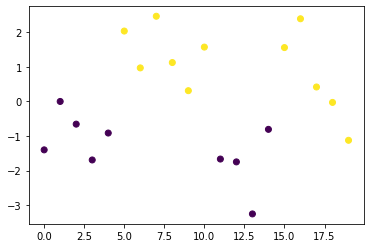

In [ ]:

plt.scatter(list(range(len(x))),x, c=z)

In [ ]:
x,z

(tensor([-1.3998e+00, -1.2692e-03, -6.5672e-01, -1.6916e+00, -9.1379e-01,
          2.0331e+00,  9.6820e-01,  2.4606e+00,  1.1227e+00,  3.0998e-01,
          1.5695e+00, -1.6654e+00, -1.7475e+00, -3.2506e+00, -8.0724e-01,
          1.5555e+00,  2.3876e+00,  4.1671e-01, -2.9125e-02, -1.1235e+00]),
 [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1])

#### two dimentional sampling test

In [ ]:
test_model = HMM(2, [distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2)*5,torch.eye(2))])

In [ ]:
x, z = test_model.sample(200)

In [ ]:
torch.nn.functional.softmax(test_model.transition_model.unnormalized_transition_matrix, dim=0)


tensor([[0.7884, 0.0731],
        [0.2116, 0.9269]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

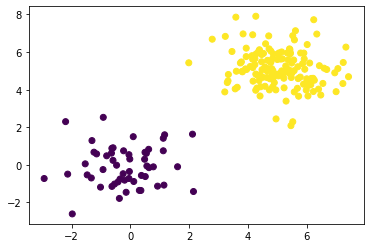

In [ ]:
plt.scatter(x[:,0],x[:,1], c=z)

Let's try hard-coding an HMM for generating fake words. (We'll also add some helper functions for encoding and decoding strings.)

We will assume that the system has one state for generating vowels and one state for generating consonants, and the transition matrix has 0s on the diagonal---in other words, the system cannot stay in the vowel state or the consonant state for one than one timestep; it has to switch.

Since we pass the transition matrix through a softmax, to get 0s we set the unnormalized parameter values to $-\infty$.

In [ ]:
test_distr = distrib.Normal(5,1)

In [ ]:
torch.exp(test_distr.log_prob(torch.Tensor([4])))

tensor([0.2420])

In [ ]:
x = np.linspace(0, 10, 1000)


In [ ]:
q0_density = torch.exp(test_distr.log_prob(torch.Tensor(x))).numpy()


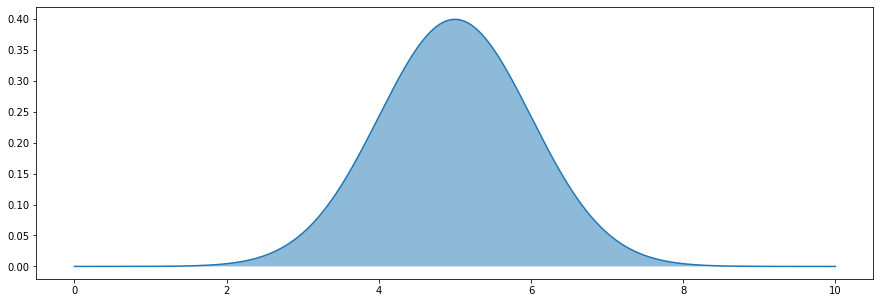

In [ ]:
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(15, 5))
ax1.plot(x, q0_density); ax1.fill_between(x, q0_density, 0, alpha=0.5)



## The Three Problems

In a [classic tutorial](https://www.cs.cmu.edu/~cga/behavior/rabiner1.pdf) on HMMs, Lawrence Rabiner describes "three problems" that need to be solved before you can effectively use an HMM. They are:
- Problem 1: How do we efficiently compute $p(\mathbf{x})$?
- Problem 2: How do we find the most likely state sequence $\mathbf{z}$ that could have generated the data? 
- Problem 3: How do we train the model?

In the rest of the notebook, we will see how to solve each problem and implement the solutions in PyTorch.

### Problem 1: How do we compute $p(\mathbf{x})$?


#### *Why?*
Why might we care about computing $p(\mathbf{x})$? Here's two reasons.
* Given two HMMs, $\theta_1$ and $\theta_2$, we can compute the likelihood of some data $\mathbf{x}$ under each model, $p_{\theta_1}(\mathbf{x})$ and $p_{\theta_2}(\mathbf{x})$, to decide which model is a better fit to the data. 

  (For example, given an HMM for English speech and an HMM for French speech, we could compute the likelihood given each model, and pick the model with the higher likelihood to infer whether the person is speaking English or French.)
* Being able to compute $p(\mathbf{x})$ gives us a way to train the model, as we will see later.

#### *How?*
Given that we want $p(\mathbf{x})$, how do we compute it?

We've assumed that the data is generated by visiting some sequence of states $\mathbf{z}$ and picking an output $x_t$ for each $z_t$ from the emission distribution $p(x_t|z_t)$. So if we knew $\mathbf{z}$, then the probability of $\mathbf{x}$ could be computed as follows:

$$p(\mathbf{x}|\mathbf{z}) = \prod_{t} p(x_t|z_t) p(z_t|z_{t-1})$$

However, we don't know $\mathbf{z}$; it's hidden. But we do know the probability of any given $\mathbf{z}$, independent of what we observe. So we could get the probability of $\mathbf{x}$ by summing over the different possibilities for $\mathbf{z}$, like this:

$$p(\mathbf{x}) = \sum_{\mathbf{z}} p(\mathbf{x}|\mathbf{z}) p(\mathbf{z}) = \sum_{\mathbf{z}} \prod_{t} p(x_t|z_t) p(z_t|z_{t-1})$$

The problem is: if you try to take that sum directly, you will need to compute $N^T$ terms. This is impossible to do for anything but very short sequences. For example, let's say the sequence is of length $T=100$ and there are $N=2$ possible states. Then we would need to check $N^T = 2^{100} \approx 10^{30}$ different possible state sequences.

We need a way to compute $p(\mathbf{x})$ that doesn't require us to explicitly calculate all $N^T$ terms. For this, we use the forward algorithm.

________

<u><b>The Forward Algorithm</b></u>

> for $s=1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\alpha_{s,1} := b_s(x_1) \cdot \pi_s$ 
> 
> for $t = 2 \rightarrow T$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;for $s = 1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
> $\alpha_{s,t} := b_s(x_t) \cdot \underset{s'}{\sum} A_{s, s'} \cdot \alpha_{s',t-1} $
> 
> $p(\mathbf{x}) := \underset{s}{\sum} \alpha_{s,T}$\
> return $p(\mathbf{x})$
________


The forward algorithm is much faster than enumerating all $N^T$ possible state sequences: it requires only $O(N^2T)$ operations to run, since each step is mostly multiplying the vector of forward variables by the transition matrix. (And very often we can reduce that complexity even further, if the transition matrix is sparse.)

There is one practical problem with the forward algorithm as presented above: it is prone to underflow due to multiplying a long chain of small numbers, since probabilities are always between 0 and 1. Instead, let's do everything in the log domain. In the log domain, a multiplication becomes a sum, and a sum becomes a [logsumexp](https://lorenlugosch.github.io/posts/2020/06/logsumexp/).  

________

<u><b>The Forward Algorithm (Log Domain)</b></u>

> for $s=1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\text{log }\alpha_{s,1} := \text{log }b_s(x_1) + \text{log }\pi_s$ 
> 
> for $t = 2 \rightarrow T$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;for $s = 1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
> $\text{log }\alpha_{s,t} := \text{log }b_s(x_t) +  \underset{s'}{\text{logsumexp}} \left( \text{log }A_{s, s'} + \text{log }\alpha_{s',t-1} \right)$
> 
> $\text{log }p(\mathbf{x}) := \underset{s}{\text{logsumexp}} \left( \text{log }\alpha_{s,T} \right)$\
> return $\text{log }p(\mathbf{x})$
________

Now that we have a numerically stable version of the forward algorithm, let's implement it in PyTorch. 

In [ ]:

def HMM_forward(self, x, T):
  """
  x : IntTensor of shape (batch size, T_max)
  T : IntTensor of shape (batch size)

  Compute log p(x) for each example in the batch.
  T = length of each example
  """
  if self.is_cuda:
  	x = x.cuda()
  	T = T.cuda()

  batch_size = x.shape[0]; T_max = x.shape[1]
  log_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
  log_alpha = torch.zeros(batch_size, T_max, self.N) # table (sample, t, state) containing log probability of observations from sample to time t and being in state (in time t)
  if self.is_cuda: log_alpha = log_alpha.cuda()

  print(log_state_priors)
  log_alpha[:, 0, :] = self.emission_model(x[:,0]) + log_state_priors # emission_model - log prob for each distr
  for t in range(1, T_max):
    log_alpha[:, t, :] = self.emission_model(x[:,t]) + self.transition_model(log_alpha[:, t-1, :])

  # Select the sum for the final timestep (each x may have different length).
  #print("alpha\n", log_alpha)
  log_sums = log_alpha.logsumexp(dim=2)
  #print("log_sums\n", log_sums)
  #log_probs = torch.gather(log_sums, 1, T.view(1,-1))
  log_probs = torch.gather(log_sums, 1, T.view(-1,1)-1)
  return log_probs

def emission_model_forward(self, x_t): ## TODO
  #out = self.distributions.log_prob(x_t)
  #out = 
  out  = []
  for state in range(self.N):
    out.append( self.distributions[state].log_prob(x_t) )
  result = torch.stack(out, dim = 1)
  #print("emission probs\n",result)
  return result

def transition_model_forward(self, log_alpha):
  """
  log_alpha : Tensor of shape (batch size, N)
  Multiply previous timestep's alphas by transition matrix (in log domain)
  """
  log_transition_matrix = torch.nn.functional.log_softmax(self.unnormalized_transition_matrix, dim=0)

  # Matrix multiplication in the log domain
  out = log_domain_matmul(log_transition_matrix, log_alpha.transpose(0,1)).transpose(0,1)
  return out

def log_domain_matmul(log_A, log_B):
	"""
	log_A : m x n
	log_B : n x p
	output : m x p matrix

	Normally, a matrix multiplication
	computes out_{i,j} = sum_k A_{i,k} x B_{k,j}

	A log domain matrix multiplication
	computes out_{i,j} = logsumexp_k log_A_{i,k} + log_B_{k,j}
	"""
	m = log_A.shape[0]
	n = log_A.shape[1]
	p = log_B.shape[1]

	# log_A_expanded = torch.stack([log_A] * p, dim=2)
	# log_B_expanded = torch.stack([log_B] * m, dim=0)
    # fix for PyTorch > 1.5 by egaznep on Github:
	log_A_expanded = torch.reshape(log_A, (m,n,1))
	log_B_expanded = torch.reshape(log_B, (1,n,p))

	elementwise_sum = log_A_expanded + log_B_expanded
	out = torch.logsumexp(elementwise_sum, dim=1)

	return out

TransitionModel.forward = transition_model_forward
EmissionModel.forward = emission_model_forward
HMM.forward = HMM_forward

#### Test forward method

In [ ]:
test_model = HMM(2, [distrib.Normal(-1,1), distrib.Normal(1, 1)])

In [ ]:
x, states = test_model.sample(30)

In [ ]:
#T =torch.Tensor([10,10,10], dtype= torch.int64)
T = torch.ones([1,3], dtype=torch.int64)*10
T.view(-1, 1)

tensor([[10],
        [10],
        [10]])

In [ ]:
test_model(torch.reshape(x, (3, 10)), T)

tensor([-0.3451, -1.2314], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
emission probs
 tensor([[-1.0122, -2.1485],
        [-3.7534, -0.9915],
        [-1.6459, -1.2343]], device='cuda:0')
emission probs
 tensor([[-4.3764, -1.1172],
        [-2.5312, -0.9398],
        [-0.9971, -2.2065]], device='cuda:0')
emission probs
 tensor([[-2.5485, -0.9379],
        [-1.1631, -4.5607],
        [-1.2755, -4.9643]], device='cuda:0')
emission probs
 tensor([[-0.9397, -3.3475],
        [-0.9247, -3.1390],
        [-2.5072, -0.9426]], device='cuda:0')
emission probs
 tensor([[-2.5871, -0.9340],
        [-1.9484, -1.0786],
        [-2.4330, -0.9527]], device='cuda:0')
emission probs
 tensor([[-1.0313, -3.9793],
        [-1.1017, -1.8925],
        [-3.3649, -9.7884]], device='cuda:0')
emission probs
 tensor([[-1.0225, -3.9325],
        [-3.0008, -0.9198],
        [-3.8865, -1.0141]], device='cuda:0')
emission probs
 tensor([[-1.9762, -6.8845],
        [-1.4726, -1.3680],
        [-3.5035, -0.9564]]

tensor([[-22.1384],
        [-15.7681],
        [-17.7198]], device='cuda:0', grad_fn=<GatherBackward0>)

#### *Side note: deriving the forward algorithm*

If you're interested in understanding how the forward algorithm actually computes $p(\mathbf{x})$, read this section; if not, skip to the next part on "Problem 2" (finding the most likely state sequence).



To derive the forward algorithm, start by deriving the forward variable:

$
\begin{align} 
    \alpha_{s,t} &= p(x_1, x_2, \dots, x_t, z_t=s) \\
     &= p(x_t | x_1, x_2, \dots, x_{t-1}, z_t = s) \cdot p(x_1, x_2, \dots, x_{t-1}, z_t = s)  \\ 
    &= p(x_t | z_t = s) \cdot p(x_1, x_2, \dots, x_{t-1}, z_t = s) \\
    &= p(x_t | z_t = s) \cdot \left( \sum_{s'} p(x_1, x_2, \dots, x_{t-1}, z_{t-1}=s', z_t = s) \right)\\
    &= p(x_t | z_t = s) \cdot \left( \sum_{s'} p(z_t = s | x_1, x_2, \dots, x_{t-1}, z_{t-1}=s') \cdot p(x_1, x_2, \dots, x_{t-1}, z_{t-1}=s') \right)\\
    &= \underbrace{p(x_t | z_t = s)}_{\text{emission model}} \cdot \left( \sum_{s'} \underbrace{p(z_t = s | z_{t-1}=s')}_{\text{transition model}} \cdot \underbrace{p(x_1, x_2, \dots, x_{t-1}, z_{t-1}=s')}_{\text{forward variable for previous timestep}} \right)\\
    &= b_s(x_t) \cdot \left( \sum_{s'} A_{s, s'} \cdot \alpha_{s',t-1} \right)
\end{align}
$

I'll explain how to get to each line of this equation from the previous line. 

Line 1 is the definition of the forward variable $\alpha_{s,t}$.

Line 2 is the chain rule ($p(A,B) = p(A|B) \cdot p(B)$, where $A$ is $x_t$ and $B$ is all the other variables).

In Line 3, we apply Assumption 2: the probability of observation $x_t$ depends only on the current state $z_t$.

In Line 4, we marginalize over all the possible states in the previous timestep $t-1$.

In Line 5, we apply the chain rule again.

In Line 6, we apply Assumption 1: the current state depends only on the previous state.

In Line 7, we substitute in the emission probability, the transition probability, and the forward variable for the previous timestep, to get the complete recursion.

The formula above can be used for $t = 2 \rightarrow T$. At $t=1$, there is no previous state, so instead of the transition matrix $A$, we use the state priors $\pi$, which tell us the probability of starting in each state. Thus for $t=1$, the forward variables are computed as follows:

$$\begin{align} 
\alpha_{s,1} &= p(x_1, z_1=s) \\
  &= p(x_1 | z_1 = s) \cdot p(z_1 = s)  \\ 
&= b_s(x_1) \cdot \pi_s
\end{align}$$

Finally, to compute $p(\mathbf{x}) = p(x_1, x_2, \dots, x_T)$, we marginalize over $\alpha_{s,T}$, the forward variables computed in the last timestep:

$$\begin{align*} 
p(\mathbf{x}) &= \sum_{s} p(x_1, x_2, \dots, x_T, z_T = s) \\ 
&= \sum_{s} \alpha_{s,T}
\end{align*}$$

You can get from this formulation to the log domain formulation by taking the log of the forward variable, and using these identities:
- $\text{log }(a \cdot b) = \text{log }a + \text{log }b$
- $\text{log }(a + b) = \text{log }(e^{\text{log }a} + e^{\text{log }b}) = \text{logsumexp}(\text{log }a, \text{log }b)$

### Problem 2: How do we compute $\underset{\mathbf{z}}{\text{argmax }} p(\mathbf{z}|\mathbf{x})$?

Given an observation sequence $\mathbf{x}$, we may want to find the most likely sequence of states that could have generated $\mathbf{x}$. (Given the sequence of selfies, we want to infer what cities the friend visited.) In other words, we want $\underset{\mathbf{z}}{\text{argmax }} p(\mathbf{z}|\mathbf{x})$.

We can use Bayes' rule to rewrite this expression:
$$\begin{align*} 
    \underset{\mathbf{z}}{\text{argmax }} p(\mathbf{z}|\mathbf{x}) &= \underset{\mathbf{z}}{\text{argmax }} \frac{p(\mathbf{x}|\mathbf{z}) p(\mathbf{z})}{p(\mathbf{x})} \\ 
    &= \underset{\mathbf{z}}{\text{argmax }} p(\mathbf{x}|\mathbf{z}) p(\mathbf{z})
\end{align*}$$

Hmm! That last expression, $\underset{\mathbf{z}}{\text{argmax }} p(\mathbf{x}|\mathbf{z}) p(\mathbf{z})$, looks suspiciously similar to the intractable expression we encountered before introducing the forward algorithm, $\underset{\mathbf{z}}{\sum} p(\mathbf{x}|\mathbf{z}) p(\mathbf{z})$.

And indeed, just as the intractable *sum* over all $\mathbf{z}$ can be implemented efficiently using the forward algorithm, so too this intractable *argmax* can be implemented efficiently using a similar divide-and-conquer algorithm: the legendary Viterbi algorithm!

________

<u><b>The Viterbi Algorithm</b></u>

> for $s=1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\delta_{s,1} := b_s(x_1) \cdot \pi_s$\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\psi_{s,1} := 0$
>
> for $t = 2 \rightarrow T$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;for $s = 1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\delta_{s,t} := b_s(x_t) \cdot \left( \underset{s'}{\text{max }} A_{s, s'} \cdot \delta_{s',t-1} \right)$\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\psi_{s,t} := \underset{s'}{\text{argmax }} A_{s, s'} \cdot \delta_{s',t-1}$
> 
> $z_T^* := \underset{s}{\text{argmax }} \delta_{s,T}$\
> for $t = T-1 \rightarrow 1$:\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$z_{t}^* := \psi_{z_{t+1}^*,t+1}$
> 
> $\mathbf{z}^* := \{z_{1}^*, \dots, z_{T}^* \}$\
return $\mathbf{z}^*$
________

The Viterbi algorithm looks somewhat gnarlier than the forward algorithm, but it is essentially the same algorithm, with two tweaks: 1) instead of taking the sum over previous states, we take the max; and 2) we record the argmax of the previous states in a table, and loop back over this table at the end to get $\mathbf{z}^*$, the most likely state sequence. (And like the forward algorithm, we should run the Viterbi algorithm in the log domain for better numerical stability.) 

Let's add the Viterbi algorithm to our PyTorch model:

In [ ]:
def viterbi(self, x, T):
  """
  x : IntTensor of shape (batch size, T_max)
  T : IntTensor of shape (batch size)
  Find argmax_z log p(x|z) for each (x) in the batch.
  """
  if self.is_cuda:
    x = x.cuda()
    T = T.cuda()

  batch_size = x.shape[0]; T_max = x.shape[1]
  log_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
  log_delta = torch.zeros(batch_size, T_max, self.N).float()
  psi = torch.zeros(batch_size, T_max, self.N).long()
  if self.is_cuda:
    log_delta = log_delta.cuda()
    psi = psi.cuda()

  log_delta[:, 0, :] = self.emission_model(x[:,0]) + log_state_priors
  for t in range(1, T_max):
    max_val, argmax_val = self.transition_model.maxmul(log_delta[:, t-1, :])
    log_delta[:, t, :] = self.emission_model(x[:,t]) + max_val
    psi[:, t, :] = argmax_val

  # Get the log probability of the best path
  log_max = log_delta.max(dim=2)[0]
  best_path_scores = torch.gather(log_max, 1, T.view(-1,1) - 1)

  # This next part is a bit tricky to parallelize across the batch,
  # so we will do it separately for each example.
  z_star = []
  for i in range(0, batch_size):
    z_star_i = [ log_delta[i, T[i] - 1, :].max(dim=0)[1].item() ]
    for t in range(T[i] - 1, 0, -1):
      z_t = psi[i, t, z_star_i[0]].item()
      z_star_i.insert(0, z_t)

    z_star.append(z_star_i)

  return z_star, best_path_scores # return both the best path and its log probability

def transition_model_maxmul(self, log_alpha):
  log_transition_matrix = torch.nn.functional.log_softmax(self.unnormalized_transition_matrix, dim=0)

  out1, out2 = maxmul(log_transition_matrix, log_alpha.transpose(0,1))
  return out1.transpose(0,1), out2.transpose(0,1)

def maxmul(log_A, log_B):
	"""
	log_A : m x n
	log_B : n x p
	output : m x p matrix

	Similar to the log domain matrix multiplication,
	this computes out_{i,j} = max_k log_A_{i,k} + log_B_{k,j}
	"""
	m = log_A.shape[0]
	n = log_A.shape[1]
	p = log_B.shape[1]

	log_A_expanded = torch.stack([log_A] * p, dim=2)
	log_B_expanded = torch.stack([log_B] * m, dim=0)

	elementwise_sum = log_A_expanded + log_B_expanded
	out1,out2 = torch.max(elementwise_sum, dim=1)

	return out1,out2

TransitionModel.maxmul = transition_model_maxmul
HMM.viterbi = viterbi

### Test viterbi

In [ ]:
test_model = HMM(2, [distrib.Normal(-1,1), distrib.Normal(1, 1)])

In [ ]:
x, states = test_model.sample(10)

In [ ]:
x, states

(tensor([ 1.9858,  0.0714,  1.2443,  3.0269, -1.8505, -0.5393,  0.8847, -0.5858,
          1.0002, -0.4509]), [1, 1, 1, 1, 0, 0, 1, 1, 1, 1])

In [ ]:
T = torch.ones([1], dtype=torch.int64)*10


In [ ]:
viterbi_results = test_model.viterbi(torch.reshape(x, (1, 10)), T)

emission probs
 tensor([[-5.3763, -1.4048]], device='cuda:0')
emission probs
 tensor([[-1.4929, -1.3501]], device='cuda:0')
emission probs
 tensor([[-3.4374, -0.9488]], device='cuda:0')
emission probs
 tensor([[-9.0271, -2.9732]], device='cuda:0')
emission probs
 tensor([[-1.2806, -4.9815]], device='cuda:0')
emission probs
 tensor([[-1.0251, -2.1036]], device='cuda:0')
emission probs
 tensor([[-2.6951, -0.9256]], device='cuda:0')
emission probs
 tensor([[-1.0047, -2.1763]], device='cuda:0')
emission probs
 tensor([[-2.9194, -0.9189]], device='cuda:0')
emission probs
 tensor([[-1.0697, -1.9716]], device='cuda:0')


In [ ]:
viterbi_results

([[1, 1, 1, 1, 0, 0, 1, 1, 1, 1]],
 tensor([[-20.1063]], device='cuda:0', grad_fn=<GatherBackward0>))

In [ ]:
test_model.forward(torch.reshape(x, (1, 10)), T)

tensor([-0.7065, -0.6800], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
emission probs
 tensor([[-5.3763, -1.4048]], device='cuda:0')
emission probs
 tensor([[-1.4929, -1.3501]], device='cuda:0')
emission probs
 tensor([[-3.4374, -0.9488]], device='cuda:0')
emission probs
 tensor([[-9.0271, -2.9732]], device='cuda:0')
emission probs
 tensor([[-1.2806, -4.9815]], device='cuda:0')
emission probs
 tensor([[-1.0251, -2.1036]], device='cuda:0')
emission probs
 tensor([[-2.6951, -0.9256]], device='cuda:0')
emission probs
 tensor([[-1.0047, -2.1763]], device='cuda:0')
emission probs
 tensor([[-2.9194, -0.9189]], device='cuda:0')
emission probs
 tensor([[-1.0697, -1.9716]], device='cuda:0')
alpha
 tensor([[[ -6.0828,  -2.0848],
         [ -5.5228,  -3.5680],
         [ -8.4743,  -4.6095],
         [-15.5688,  -7.7149],
         [-11.0337, -12.8356],
         [-12.3748, -13.9677],
         [-15.3790, -14.0570],
         [-16.2054, -16.2867],
         [-19.3141, -17.0341],
         [-19.7015,

tensor([[-18.6702]], device='cuda:0', grad_fn=<GatherBackward0>)

In [ ]:
states

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1]

The two scores are the same! That's because in this instance there is only one possible path through the HMM, so the probability of the most likely path is the same as the sum of the probabilities of all possible paths.

In general, though, the forward score and Viterbi score will always be somewhat close. This is because of a property of the $\text{logsumexp}$ function: $\text{logsumexp}(\mathbf{x}) \approx \max (\mathbf{x})$. ($\text{logsumexp}$ is sometimes referred to as the "smooth maximum" function.)

In [ ]:
x = torch.tensor([1., 2., 3.])
print(x.max(dim=0)[0])
print(x.logsumexp(dim=0))

tensor(3.)
tensor(3.4076)


### Problem 3: How do we train the model?





Earlier, we hard-coded an HMM to have certain behavior. What we would like to do instead is have the HMM learn to model the data on its own. And while it is possible to use supervised learning with an HMM (by hard-coding the emission model or the transition model) so that the states have a particular interpretation, the really cool thing about HMMs is that they are naturally unsupervised learners, so they can learn to use their different states to represent different patterns in the data, without the programmer needing to indicate what each state means.

Like many machine learning models, an HMM can be trained using maximum likelihood estimation, i.e.:

$$\theta^* = \underset{\theta}{\text{argmin }} -\sum_{\mathbf{x}^i}\text{log }p_{\theta}(\mathbf{x}^i)$$

where $\mathbf{x}^1, \mathbf{x}^2, \dots$ are training examples. 

The standard method for doing this is the Expectation-Maximization (EM) algorithm, which for HMMs is also called the "Baum-Welch" algorithm. In EM training, we alternate between an "E-step", where we estimate the values of the latent variables, and an "M-step", where the model parameters are updated given the estimated latent variables. (Think $k$-means, where you guess which cluster each data point belongs to, then reestimate where the clusters are, and repeat.) The EM algorithm has some nice properties: it is guaranteed at each step to decrease the loss function, and the E-step and M-step may have an exact closed form solution, in which case no pesky learning rates are required.

But because the HMM forward algorithm is differentiable with respect to all the model parameters, we can also just take advantage of automatic differentiation methods in libraries like PyTorch and try to minimize $-\text{log }p_{\theta}(\mathbf{x})$ directly, by backpropagating through the forward algorithm and running stochastic gradient descent. That means we don't need to write any additional HMM code to implement training: `loss.backward()` is all you need.

Here we will implement SGD training for an HMM in PyTorch. First, some helper classes:

In [ ]:
import torch.utils.data
from collections import Counter
from sklearn.model_selection import train_test_split

class TextDataset(torch.utils.data.Dataset):
  def __init__(self, lines):
    self.lines = lines # list of strings
    collate = Collate() # function for generating a minibatch from strings
    self.loader = torch.utils.data.DataLoader(self, batch_size=1024, num_workers=1, shuffle=True, collate_fn=collate)

  def __len__(self):
    return len(self.lines)

  def __getitem__(self, idx):
    line = self.lines[idx].lstrip(" ").rstrip("\n").rstrip(" ").rstrip("\n")
    return line

class Collate:
  def __init__(self):
    pass

  def __call__(self, batch):
    """
    Returns a minibatch of strings, padded to have the same length.
    """
    x = []
    batch_size = len(batch)
    for index in range(batch_size):
      x_ = batch[index]

      # convert letters to integers
      x.append(encode(x_))

    # pad all sequences with 0 to have same length
    x_lengths = [len(x_) for x_ in x]
    T = max(x_lengths)
    for index in range(batch_size):
      x[index] += [0] * (T - len(x[index]))
      x[index] = torch.tensor(x[index])

    # stack into single tensor
    x = torch.stack(x)
    x_lengths = torch.tensor(x_lengths)
    return (x,x_lengths)

Let's load some training/testing data. By default, this will use the unix "words" file, but you could also use your own text file.

In [ ]:
!wget https://raw.githubusercontent.com/lorenlugosch/pytorch_HMM/master/data/train/training.txt

filename = "training.txt"

with open(filename, "r") as f:
  lines = f.readlines() # each line of lines will have one word

alphabet = list(Counter(("".join(lines))).keys())
train_lines, valid_lines = train_test_split(lines, test_size=0.1, random_state=42)
train_dataset = TextDataset(train_lines)
valid_dataset = TextDataset(valid_lines)

M = len(alphabet)

--2022-06-12 08:57:32--  https://raw.githubusercontent.com/lorenlugosch/pytorch_HMM/master/data/train/training.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2493109 (2.4M) [text/plain]
Saving to: ‘training.txt’

training.txt        100%[===================>]   2.38M  --.-KB/s    in 0.03s   

2022-06-12 08:57:33 (70.1 MB/s) - ‘training.txt’ saved [2493109/2493109]



We will use a Trainer class for training and testing the model:



In [ ]:
from tqdm import tqdm # for displaying progress bar

class Trainer:
  def __init__(self, model, lr):
    self.model = model
    self.lr = lr
    self.optimizer = torch.optim.Adam(model.parameters(), lr=self.lr, weight_decay=0.00001)
  
  def train(self, dataset):
    train_loss = 0
    num_samples = 0
    self.model.train()
    print_interval = 50
    for idx, batch in enumerate(tqdm(dataset.loader)):
      x,T = batch
      batch_size = len(x)
      num_samples += batch_size
      log_probs = self.model(x,T)
      loss = -log_probs.mean()
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      train_loss += loss.cpu().data.numpy().item() * batch_size
      if idx % print_interval == 0:
        print("loss:", loss.item())
        for _ in range(5):
          sampled_x, sampled_z = self.model.sample()
          print(decode(sampled_x))
          print(sampled_z)
    train_loss /= num_samples
    return train_loss

  def test(self, dataset):
    test_loss = 0
    num_samples = 0
    self.model.eval()
    print_interval = 50
    for idx, batch in enumerate(dataset.loader):
      x,T = batch
      batch_size = len(x)
      num_samples += batch_size
      log_probs = self.model(x,T)
      loss = -log_probs.mean()
      test_loss += loss.cpu().data.numpy().item() * batch_size
      if idx % print_interval == 0:
        print("loss:", loss.item())
        sampled_x, sampled_z = self.model.sample()
        print(decode(sampled_x))
        print(sampled_z)
    test_loss /= num_samples
    return test_loss

Finally, initialize the model and run the main training loop. Every 50 batches, the code will produce a few samples from the model. Over time, these samples should look more and more realistic.

In [ ]:
# Initialize model
model = HMM(N=64, M=M)

# Train the model
num_epochs = 10
trainer = Trainer(model, lr=0.01)

for epoch in range(num_epochs):
        print("========= Epoch %d of %d =========" % (epoch+1, num_epochs))
        train_loss = trainer.train(train_dataset)
        valid_loss = trainer.test(valid_dataset)

        print("========= Results: epoch %d of %d =========" % (epoch+1, num_epochs))
        print("train loss: %.2f| valid loss: %.2f\n" % (train_loss, valid_loss) )

========= Epoch 1 of 10 =========


  0%|          | 0/208 [00:00<?, ?it/s]

loss: 38.220359802246094
ovS
BqfdTS
[4, 17, 26, 24, 49, 27, 29, 47, 12, 47]

  1%|▏         | 3/208 [00:00<00:23,  8.55it/s]


SzhiieL
tZ
[32, 36, 55, 47, 35, 57, 14, 60, 59, 38]
-OVlKNufaM
[60, 18, 60, 50, 32, 57, 20, 51, 33, 58]
mJkSOib
Kw
[18, 39, 60, 17, 38, 55, 51, 47, 32, 50]
vsIWdPnBnA
[0, 8, 56, 27, 17, 23, 47, 39, 58, 57]


 25%|██▌       | 53/208 [00:03<00:10, 14.50it/s]

loss: 32.680179595947266
gdiaEscYSs
[32, 30, 50, 14, 48, 43, 20, 42, 26, 29]
iUvMlHiiwo
[29, 43, 30, 14, 48, 3, 46, 59, 29, 40]
SfatoBrGIK
[20, 53, 2, 46, 2, 57, 41, 11, 40, 24]
mMilVb
Yxx
[44, 19, 40, 40, 60, 27, 58, 50, 0, 13]
sUhYqrlIMx
[33, 27, 52, 54, 39, 41, 48, 63, 22, 38]


 50%|████▉     | 103/208 [00:07<00:07, 13.87it/s]

loss: 30.349931716918945
pRrsinkell
[50, 62, 12, 45, 62, 22, 58, 38, 59, 15]
ihLhnbisud
[6, 54, 51, 16, 31, 36, 54, 34, 16, 39]
oraonioiqs
[0, 41, 17, 52, 0, 59, 63, 22, 0, 14]
juciweufcn
[44, 62, 49, 1, 50, 0, 43, 47, 35, 20]
sicfadnxrd
[44, 19, 49, 49, 1, 46, 22, 48, 3, 38]


 74%|███████▎  | 153/208 [00:10<00:03, 15.09it/s]

loss: 28.456218719482422
viycelurTb
[44, 62, 12, 14, 45, 16, 14, 41, 63, 39]
oiomomyorb
[18, 62, 24, 45, 14, 45, 15, 24, 41, 39]
ecSlqvFnag
[44, 49, 31, 59, 13, 51, 15, 22, 63, 53]
hrsoniedil
[18, 12, 31, 24, 0, 47, 12, 39, 62, 22]
penfniTlru
[51, 54, 63, 33, 22, 50, 49, 31, 37, 15]


 98%|█████████▊| 203/208 [00:13<00:00, 14.28it/s]

loss: 26.394794464111328
dascidomyH
[34, 14, 5, 46, 62, 34, 24, 45, 24, 45]
tFshXdrduV
[44, 15, 22, 31, 54, 34, 54, 34, 40, 57]
twitcgoesr
[44, 21, 43, 12, 5, 58, 31, 54, 5, 39]
cudu
ltilr
[44, 62, 55, 14, 5, 9, 46, 62, 44, 41]
ramsVfroag
[18, 24, 45, 24, 45, 24, 31, 62, 35, 62]


100%|██████████| 208/208 [00:14<00:00, 14.73it/s]


loss: 26.797958374023438
bessrinive
[44, 63, 22, 49, 31, 62, 44, 62, 53, 54]
========= Results: epoch 1 of 10 =========
train loss: 30.79| valid loss: 26.61

========= Epoch 2 of 10 =========


  0%|          | 1/208 [00:00<00:40,  5.14it/s]

loss: 26.685302734375
Marusfliih
[44, 63, 41, 62, 35, 63, 39, 59, 63, 46]
ateemmcala
[14, 0, 54, 24, 45, 62, 35, 63, 39, 63]
ufKsllpXti
[14, 45, 62, 46, 53, 0, 26, 62, 46, 62]
eOmogoates
[33, 14, 45, 24, 35, 20, 49, 31, 54, 5]
-lianhertr
[18, 39, 59, 63, 22, 31, 54, 22, 49, 41]


 25%|██▌       | 53/208 [00:03<00:10, 15.15it/s]

loss: 26.105327606201172
rietreeguc
[41, 62, 49, 31, 41, 62, 63, 35, 62, 35]
rinnibuDrE
[41, 62, 5, 45, 62, 44, 14, 1, 41, 62]
srarcronha
[44, 41, 63, 22, 35, 41, 63, 22, 50, 63]
hotingifal
[18, 63, 31, 62, 22, 38, 62, 34, 63, 39]
pIbcantres
[16, 15, 22, 35, 63, 22, 31, 41, 63, 46]


 50%|████▉     | 103/208 [00:06<00:07, 14.15it/s]

loss: 25.067440032958984
radatepnty
[41, 63, 39, 63, 31, 62, 46, 22, 31, 62]
iasiaslial
[62, 63, 45, 62, 63, 46, 6, 54, 63, 53]
ancigeroab
[63, 22, 31, 62, 35, 54, 41, 24, 14, 39]
pedigaceXa
[16, 54, 34, 62, 35, 49, 35, 63, 34, 63]
socuschewe
[48, 63, 35, 14, 45, 46, 50, 63, 39, 62]


 74%|███████▎  | 153/208 [00:10<00:03, 13.95it/s]

loss: 24.631916046142578
giTmmcroov
[18, 63, 61, 45, 45, 35, 41, 24, 47, 34]
ultoupipia
[15, 22, 31, 54, 5, 45, 62, 39, 62, 63]
macencrepl
[18, 63, 38, 63, 22, 35, 17, 12, 16, 6]
phocarnoer
[16, 6, 63, 22, 63, 22, 38, 6, 54, 41]
racotlipre
[41, 63, 35, 63, 31, 41, 62, 35, 41, 54]


 98%|█████████▊| 203/208 [00:13<00:00, 14.80it/s]

loss: 24.934513092041016
sireinapet
[44, 15, 22, 38, 62, 22, 24, 45, 49, 31]
unocismomr
[15, 22, 63, 46, 62, 46, 50, 24, 45, 17]
udsliglant
[15, 22, 44, 6, 62, 35, 6, 63, 22, 31]
tribineaai
[33, 41, 62, 39, 62, 31, 54, 5, 43, 62]
dumaPtesen
[32, 14, 45, 63, 46, 31, 54, 45, 62, 22]


100%|██████████| 208/208 [00:13<00:00, 14.90it/s]


loss: 24.86551284790039
couchide-u
[35, 63, 14, 46, 50, 62, 34, 54, 5, 52]
========= Results: epoch 2 of 10 =========
train loss: 25.27| valid loss: 24.60

========= Epoch 3 of 10 =========


  0%|          | 0/208 [00:00<?, ?it/s]

loss: 24.48318099975586
Anunbofich
[21, 0, 15, 22, 38, 63, 22, 62, 46, 50]
broteeyoca
[26, 41, 63, 31, 59, 49, 25, 24, 35, 63]
pmflousiim
[18, 36, 44, 6, 24, 14, 46, 50, 62, 31]
pqygiaRica
[26, 6, 28, 38, 59, 63, 22, 62, 35, 63]


  1%|▏         | 3/208 [00:00<00:20, 10.08it/s]

viotederee
[34, 62, 63, 31, 62, 34, 54, 41, 19, 49]


 25%|██▍       | 51/208 [00:04<00:15, 10.20it/s]

loss: 24.424537658691406
cpanUidado
[46, 31, 63, 22, 24, 47, 34, 63, 38, 54]
rilitrodin
[41, 63, 39, 62, 31, 41, 63, 34, 62, 35]
croncKrous
[35, 41, 63, 22, 35, 54, 41, 24, 14, 46]
onlersnong
[63, 22, 31, 54, 5, 44, 6, 63, 22, 38]
calosmianD
[18, 63, 39, 63, 5, 45, 62, 63, 22, 49]


 50%|████▉     | 103/208 [00:07<00:07, 14.36it/s]

loss: 24.104280471801758
Qandeblver
[18, 63, 22, 38, 63, 39, 6, 0, 54, 41]
ssheruoian
[46, 31, 50, 54, 41, 14, 31, 62, 63, 45]
inuuisiote
[15, 22, 24, 17, 62, 45, 62, 63, 31, 62]
tlDritrito
[26, 6, 1, 41, 62, 31, 41, 62, 31, 24]
priprighei
[26, 41, 62, 35, 41, 62, 35, 50, 62, 46]


 74%|███████▎  | 153/208 [00:11<00:03, 14.59it/s]

loss: 24.04503631591797
Dystrinlem
[18, 1, 46, 31, 41, 62, 0, 43, 1, 45]
anurateaef
[63, 22, 62, 34, 63, 31, 54, 17, 62, 2]
sentialcce
[44, 63, 22, 31, 62, 63, 39, 49, 31, 62]
cholyemall
[35, 50, 63, 39, 62, 63, 45, 63, 39, 6]
cortailexl
[35, 63, 22, 31, 63, 39, 6, 62, 39, 6]


 98%|█████████▊| 203/208 [00:14<00:00, 13.75it/s]

loss: 24.293285369873047
allewovong
[63, 39, 6, 54, 41, 63, 34, 63, 22, 38]
wanvorNima
[18, 63, 22, 34, 54, 5, 44, 62, 45, 63]
phiturride
[26, 50, 62, 31, 54, 5, 41, 62, 34, 54]
mastideoch
[18, 63, 22, 31, 62, 34, 62, 63, 35, 50]
ffionadept
[60, 2, 62, 63, 34, 63, 22, 62, 22, 31]


100%|██████████| 208/208 [00:14<00:00, 13.95it/s]


loss: 23.761920928955078
ofeadogidt
[47, 34, 54, 63, 39, 24, 32, 62, 34, 54]
========= Results: epoch 3 of 10 =========
train loss: 24.22| valid loss: 24.04

========= Epoch 4 of 10 =========


  0%|          | 1/208 [00:00<00:38,  5.39it/s]

loss: 24.110631942749023
haditonlyd
[18, 63, 34, 62, 31, 63, 39, 6, 28, 38]
thounulahe
[26, 50, 24, 14, 31, 63, 39, 49, 31, 62]
pritiotere
[26, 41, 62, 31, 62, 63, 31, 54, 41, 62]
lireormoge
[34, 54, 41, 62, 63, 5, 45, 63, 39, 62]
abolicapop
[63, 39, 63, 39, 62, 35, 63, 39, 24, 16]


 25%|██▌       | 53/208 [00:03<00:10, 14.40it/s]

loss: 23.95294189453125
divabtiala
[34, 62, 34, 63, 39, 31, 62, 63, 39, 49]
nanelnevcu
[18, 63, 22, 63, 39, 34, 62, 46, 35, 14]
sidiUmalel
[44, 62, 34, 62, 63, 45, 63, 39, 62, 39]
nalitickmp
[18, 63, 39, 62, 31, 62, 35, 19, 45, 16]
bousistore
[18, 24, 14, 46, 62, 46, 31, 54, 41, 63]


 50%|████▉     | 103/208 [00:06<00:07, 13.90it/s]

loss: 23.891273498535156
phtflatial
[26, 50, 31, 2, 6, 49, 31, 62, 63, 39]
oncreliaph
[63, 22, 35, 41, 63, 39, 62, 24, 16, 50]
Thotwusheu
[26, 50, 63, 31, 37, 62, 46, 50, 63, 22]
tysmizusSr
[31, 54, 5, 45, 62, 35, 14, 46, 26, 41]
scelathyme
[44, 35, 63, 39, 49, 31, 50, 28, 45, 62]


 73%|███████▎  | 151/208 [00:10<00:04, 12.48it/s]

loss: 24.020217895507812
Runtearent
[18, 15, 22, 31, 54, 49, 41, 63, 22, 38]
eundanevil
[51, 15, 22, 38, 63, 34, 62, 34, 63, 39]
outthredie
[24, 14, 46, 31, 50, 41, 62, 34, 62, 63]
rurdisnern
[41, 14, 39, 34, 62, 46, 0, 54, 5, 0]
Mativavnfe
[18, 63, 31, 62, 34, 63, 34, 0, 2, 54]


 98%|█████████▊| 203/208 [00:13<00:00, 13.88it/s]

loss: 23.61150360107422
kuoprymoku
[34, 54, 24, 16, 41, 62, 34, 63, 31, 14]
Atollesaro
[21, 31, 63, 39, 6, 54, 45, 49, 41, 24]
covoKolype
[35, 63, 34, 63, 39, 24, 32, 28, 16, 54]
teroninwys
[18, 54, 41, 24, 45, 62, 22, 31, 28, 46]
ghoussthor
[26, 50, 24, 14, 5, 46, 31, 50, 54, 41]


100%|██████████| 208/208 [00:14<00:00, 14.62it/s]


loss: 23.6522216796875
vedgydrero
[34, 54, 5, 32, 28, 29, 41, 54, 41, 24]
========= Results: epoch 4 of 10 =========
train loss: 23.89| valid loss: 23.85

========= Epoch 5 of 10 =========


  0%|          | 1/208 [00:00<00:38,  5.32it/s]

loss: 23.433408737182617
borsumphal
[18, 63, 5, 43, 14, 45, 16, 50, 63, 22]
hancorhate
[18, 63, 22, 35, 63, 31, 50, 63, 46, 62]
bastymangi
[48, 49, 46, 31, 28, 45, 63, 22, 38, 62]
barnonsour
[18, 63, 22, 34, 63, 22, 31, 24, 14, 41]
tistJuildo
[27, 62, 46, 31, 41, 20, 62, 39, 55, 63]


 25%|██▌       | 53/208 [00:03<00:10, 15.17it/s]

loss: 23.753307342529297
umayistedy
[15, 45, 49, 37, 62, 46, 31, 54, 38, 28]
poloteatyp
[18, 63, 39, 63, 31, 62, 46, 31, 28, 16]
inralearir
[15, 22, 41, 63, 39, 62, 63, 22, 62, 46]
rasciveopy
[18, 63, 46, 31, 62, 34, 62, 24, 16, 28]
Maumeniabr
[18, 63, 15, 45, 63, 22, 62, 63, 48, 41]


 50%|████▉     | 103/208 [00:07<00:07, 13.80it/s]

loss: 23.89297866821289
ochigousta
[63, 35, 50, 62, 53, 24, 14, 46, 31, 63]
Aspresledn
[21, 44, 16, 41, 54, 5, 6, 54, 29, 0]
vursanuido
[34, 54, 5, 44, 63, 31, 20, 62, 34, 63]
subemohrea
[44, 20, 10, 54, 45, 63, 50, 41, 62, 63]
sulogryort
[44, 20, 39, 24, 32, 41, 62, 63, 22, 31]


 74%|███████▎  | 153/208 [00:10<00:03, 14.33it/s]

loss: 23.550996780395508
ceustibral
[35, 63, 14, 46, 31, 62, 48, 41, 63, 39]
bortabastu
[48, 63, 22, 31, 63, 48, 63, 46, 31, 12]
elfucthteo
[63, 39, 3, 14, 46, 31, 50, 31, 62, 63]
inendesmic
[15, 22, 62, 22, 34, 54, 5, 45, 62, 35]
alanepyler
[63, 39, 63, 34, 63, 16, 28, 6, 54, 5]


 98%|█████████▊| 203/208 [00:13<00:00, 14.37it/s]

loss: 23.570589065551758
wyencrivil
[18, 61, 63, 22, 35, 41, 62, 34, 62, 6]
psedmegdsi
[26, 42, 54, 5, 45, 62, 53, 56, 30, 62]
untesIidan
[15, 22, 31, 54, 5, 18, 62, 34, 63, 22]
pofficalle
[18, 63, 11, 2, 62, 35, 63, 39, 6, 54]
proorinaom
[26, 41, 24, 47, 34, 62, 22, 63, 1, 45]


100%|██████████| 208/208 [00:13<00:00, 14.88it/s]


loss: 23.552005767822266
weckraisne
[41, 62, 35, 19, 41, 63, 62, 46, 0, 54]
========= Results: epoch 5 of 10 =========
train loss: 23.75| valid loss: 23.74

========= Epoch 6 of 10 =========


  0%|          | 1/208 [00:00<00:38,  5.36it/s]

loss: 23.48934555053711
dioserespe
[27, 62, 24, 42, 54, 41, 62, 46, 31, 54]
rospkitest
[41, 24, 44, 16, 31, 62, 31, 62, 46, 31]
tiitaliDet
[26, 50, 62, 35, 63, 39, 62, 34, 62, 31]
cruamosril
[26, 41, 20, 63, 45, 63, 31, 41, 62, 39]
toledetrim
[26, 63, 39, 62, 34, 49, 31, 41, 62, 45]


 25%|██▌       | 53/208 [00:03<00:10, 14.29it/s]

loss: 23.70694351196289
aptupeedis
[63, 16, 31, 20, 10, 0, 54, 56, 62, 46]
otretionem
[63, 31, 41, 62, 31, 62, 63, 22, 1, 45]
dremoustis
[26, 41, 1, 45, 24, 14, 46, 31, 62, 46]
Isleropham
[21, 46, 6, 54, 41, 24, 16, 6, 12, 45]
relsesdicu
[41, 62, 39, 42, 54, 5, 34, 62, 35, 14]


 50%|████▉     | 103/208 [00:06<00:07, 14.82it/s]

loss: 23.88528823852539
ingifelasi
[15, 22, 38, 62, 2, 54, 6, 63, 46, 62]
soerealise
[18, 63, 54, 22, 31, 63, 39, 62, 46, 54]
Tinchiollo
[26, 15, 22, 35, 50, 62, 63, 39, 6, 24]
phelluletr
[26, 50, 62, 39, 6, 20, 39, 62, 31, 41]
dirarraust
[27, 62, 34, 63, 5, 41, 63, 14, 46, 31]


 74%|███████▎  | 153/208 [00:10<00:03, 14.69it/s]

loss: 23.371965408325195
ennineacle
[15, 22, 34, 62, 22, 1, 49, 46, 6, 62]
rachersane
[18, 63, 35, 50, 54, 5, 44, 63, 34, 54]
untidatoph
[15, 22, 31, 62, 34, 49, 31, 63, 16, 50]
imalyshins
[15, 45, 49, 17, 62, 46, 50, 62, 22, 46]
tretreicac
[26, 41, 62, 31, 41, 1, 62, 35, 63, 31]


 98%|█████████▊| 203/208 [00:13<00:00, 14.24it/s]

loss: 23.569175720214844
whraunxier
[26, 50, 41, 63, 15, 22, 45, 62, 63, 5]
untmuskiva
[15, 22, 31, 24, 14, 46, 31, 62, 34, 49]
nycatelyla
[18, 28, 35, 63, 31, 54, 6, 28, 39, 49]
frassaster
[26, 41, 63, 5, 44, 1, 46, 31, 54, 5]
Sitiausklo
[18, 62, 31, 62, 63, 14, 46, 31, 6, 63]


100%|██████████| 208/208 [00:13<00:00, 14.93it/s]


loss: 24.102989196777344
hanalobNus
[18, 63, 22, 63, 39, 63, 10, 9, 14, 46]
========= Results: epoch 6 of 10 =========
train loss: 23.65| valid loss: 23.65

========= Epoch 7 of 10 =========


  0%|          | 1/208 [00:00<00:39,  5.23it/s]

loss: 23.449460983276367
anroidienr
[15, 22, 41, 24, 47, 56, 62, 63, 22, 41]
privesmyti
[26, 41, 62, 34, 54, 5, 45, 62, 31, 62]
biphopterp
[48, 62, 16, 50, 63, 16, 31, 54, 5, 16]
aridurwhad
[63, 39, 62, 34, 54, 5, 43, 50, 63, 34]
paterbalal
[26, 63, 31, 54, 5, 25, 63, 39, 63, 39]


 25%|██▌       | 53/208 [00:03<00:11, 13.45it/s]

loss: 23.892345428466797
tripessuti
[26, 41, 1, 16, 54, 5, 44, 14, 31, 62]
seagesichr
[44, 1, 49, 38, 54, 5, 62, 35, 50, 41]
Cssomatrei
[63, 5, 44, 24, 45, 49, 31, 41, 1, 62]
messiayyio
[18, 1, 46, 31, 62, 63, 23, 36, 59, 12]
eperivossc
[1, 51, 54, 5, 62, 34, 54, 5, 46, 31]


 50%|████▉     | 103/208 [00:07<00:07, 14.82it/s]

loss: 23.258758544921875
psereenusm
[26, 42, 54, 41, 1, 63, 22, 24, 46, 45]
peatolerst
[18, 1, 63, 31, 54, 6, 54, 5, 46, 31]
phaloulous
[26, 50, 63, 39, 24, 14, 39, 24, 14, 46]
suilineshi
[44, 20, 62, 39, 62, 22, 62, 46, 50, 62]
acksthalil
[63, 35, 19, 46, 31, 50, 63, 39, 62, 6]


 74%|███████▎  | 153/208 [00:10<00:04, 13.68it/s]

loss: 23.47913932800293
ingcreessl
[15, 22, 38, 54, 41, 1, 54, 5, 44, 6]
ormphypler
[63, 5, 45, 16, 50, 28, 16, 6, 54, 5]
ivicogypus
[47, 34, 62, 35, 24, 32, 28, 16, 14, 46]
susridiner
[44, 20, 5, 41, 62, 34, 62, 34, 54, 5]
stridolric
[46, 31, 41, 62, 56, 63, 39, 41, 62, 35]


 98%|█████████▊| 203/208 [00:13<00:00, 14.42it/s]

loss: 23.940227508544922
liristodit
[18, 62, 39, 62, 46, 31, 63, 39, 62, 31]
trouscless
[26, 41, 24, 14, 46, 35, 6, 54, 5, 44]
Uutympangl
[21, 14, 31, 12, 45, 16, 63, 22, 38, 6]
bigalpKync
[44, 62, 53, 63, 39, 16, 50, 62, 22, 35]
q-erseguia
[44, 6, 54, 5, 44, 1, 53, 20, 62, 63]


100%|██████████| 208/208 [00:14<00:00, 14.64it/s]


loss: 23.485172271728516
bilouleble
[48, 62, 39, 24, 14, 39, 62, 48, 6, 54]
========= Results: epoch 7 of 10 =========
train loss: 23.55| valid loss: 23.55

========= Epoch 8 of 10 =========


  0%|          | 0/208 [00:00<?, ?it/s]

loss: 23.490684509277344
rivistevio
[17, 62, 34, 62, 46, 31, 62, 34, 62, 63]
proosteoce
[26, 41, 24, 14, 46, 31, 62, 63, 35, 63]
pantatesti
[18, 63, 22, 31, 49, 31, 63, 46, 31, 62]


  1%|▏         | 3/208 [00:00<00:20,  9.89it/s]

deywhonbuc
[38, 54, 7, 43, 50, 63, 22, 51, 14, 46]
enentlembr
[21, 34, 54, 22, 31, 6, 54, 45, 51, 41]


 25%|██▌       | 53/208 [00:03<00:10, 14.85it/s]

loss: 23.670957565307617
blivobersh
[48, 6, 62, 34, 54, 10, 54, 5, 43, 50]
tryoullear
[26, 41, 28, 24, 14, 39, 6, 1, 63, 5]
Trocionerc
[26, 41, 1, 35, 62, 24, 0, 54, 5, 31]
Pohimurgss
[26, 63, 50, 62, 45, 14, 22, 38, 46, 31]
ragharsedl
[41, 49, 38, 50, 63, 5, 45, 54, 56, 6]


 50%|████▉     | 103/208 [00:07<00:07, 14.55it/s]

loss: 23.539636611938477
sednatkess
[46, 54, 29, 0, 24, 35, 19, 54, 5, 45]
vilictaaid
[34, 62, 17, 62, 46, 31, 49, 17, 62, 56]
isterricab
[21, 46, 31, 54, 5, 41, 62, 35, 63, 4]
Crapeloror
[26, 41, 1, 18, 63, 39, 24, 41, 24, 41]
sangsumosi
[44, 63, 22, 38, 46, 12, 45, 24, 42, 62]


 74%|███████▎  | 153/208 [00:10<00:03, 14.02it/s]

loss: 23.555219650268555
odcancuram
[47, 56, 35, 63, 22, 31, 54, 41, 62, 45]
sthistonio
[46, 31, 50, 62, 46, 31, 63, 37, 62, 63]
cochoginip
[35, 24, 35, 50, 24, 32, 62, 22, 1, 16]
stethority
[46, 31, 62, 31, 50, 63, 5, 62, 31, 23]
luperseuth
[6, 1, 16, 54, 5, 42, 54, 5, 46, 50]


 98%|█████████▊| 203/208 [00:13<00:00, 14.39it/s]

loss: 23.617158889770508
peniollala
[26, 63, 22, 62, 63, 39, 6, 63, 39, 1]
medlsousol
[18, 1, 56, 59, 42, 24, 14, 46, 63, 39]
acanguisti
[21, 35, 63, 22, 38, 20, 62, 46, 31, 62]
grartiaxsu
[26, 41, 63, 5, 31, 62, 63, 22, 44, 20]
Jonissluda
[18, 24, 37, 62, 46, 44, 6, 12, 56, 59]


100%|██████████| 208/208 [00:14<00:00, 14.77it/s]


loss: 23.595508575439453
Flintroplo
[26, 6, 62, 22, 31, 41, 24, 16, 6, 24]
========= Results: epoch 8 of 10 =========
train loss: 23.46| valid loss: 23.47

========= Epoch 9 of 10 =========


  0%|          | 0/208 [00:00<?, ?it/s]

loss: 23.8101749420166
ecosterioE
[21, 35, 63, 46, 31, 54, 41, 62, 63, 15]
tantedrahv
[26, 63, 22, 31, 49, 29, 41, 63, 39, 34]


  1%|▏         | 3/208 [00:00<00:21,  9.42it/s]

Oxhichocyl
[15, 22, 50, 62, 35, 50, 24, 35, 28, 39]
cksugricom
[35, 19, 44, 20, 53, 41, 1, 35, 24, 45]
braposomer
[26, 41, 1, 16, 24, 44, 24, 45, 54, 41]


 25%|██▌       | 53/208 [00:03<00:10, 14.47it/s]

loss: 23.47339630126953
Momanwlvea
[18, 24, 45, 63, 22, 25, 39, 34, 54, 49]
honstednes
[18, 63, 22, 46, 31, 54, 29, 0, 54, 5]
glodronous
[38, 6, 24, 32, 41, 63, 22, 24, 14, 42]
centylynet
[35, 63, 22, 31, 23, 6, 13, 37, 49, 31]
apbrosthae
[21, 10, 51, 41, 63, 46, 31, 41, 63, 40]


 50%|████▉     | 103/208 [00:07<00:07, 14.31it/s]

loss: 23.555282592773438
phaanachel
[26, 50, 63, 15, 22, 1, 35, 50, 62, 6]
rQoniferai
[10, 55, 24, 45, 62, 2, 54, 41, 1, 62]
Dousereste
[18, 24, 14, 42, 54, 41, 1, 46, 31, 54]
gethterede
[18, 1, 31, 50, 31, 54, 5, 54, 56, 63]
sphaincone
[44, 16, 50, 63, 15, 22, 35, 63, 37, 62]


 74%|███████▎  | 153/208 [00:10<00:03, 14.13it/s]

loss: 23.41158103942871
unilallyhe
[15, 22, 14, 39, 49, 39, 6, 28, 50, 54]
unajuiatin
[15, 22, 1, 44, 20, 62, 49, 31, 62, 22]
eizictatri
[40, 47, 34, 62, 46, 31, 49, 31, 41, 1]
nepoldicur
[18, 1, 16, 63, 39, 56, 62, 35, 63, 22]
Ulisiveran
[21, 39, 62, 46, 62, 34, 54, 41, 63, 22]


 98%|█████████▊| 203/208 [00:13<00:00, 14.31it/s]

loss: 23.691513061523438
eblifermpc
[21, 39, 6, 62, 34, 54, 5, 45, 16, 31]
chronicart
[35, 50, 41, 63, 37, 62, 35, 63, 39, 31]
dalledyunt
[18, 63, 39, 6, 1, 32, 28, 15, 22, 31]
nydlycelen
[18, 28, 29, 6, 28, 35, 63, 39, 62, 37]
beurnarest
[51, 63, 14, 5, 37, 49, 17, 62, 46, 31]


100%|██████████| 208/208 [00:14<00:00, 14.85it/s]


loss: 23.183727264404297
saisubomen
[18, 1, 40, 44, 20, 10, 54, 45, 62, 22]
========= Results: epoch 9 of 10 =========
train loss: 23.39| valid loss: 23.41

========= Epoch 10 of 10 =========


  0%|          | 1/208 [00:00<00:39,  5.20it/s]

loss: 23.200057983398438
paansuezop
[26, 63, 63, 22, 44, 20, 54, 55, 24, 16]
pslerconst
[26, 42, 6, 54, 5, 35, 63, 22, 46, 31]
quatedreba
[44, 20, 49, 31, 54, 29, 41, 1, 51, 49]
heventners
[18, 1, 34, 54, 22, 31, 0, 54, 5, 42]
sysersuftr
[18, 28, 42, 54, 5, 44, 20, 11, 31, 41]


 25%|██▌       | 53/208 [00:03<00:10, 14.34it/s]

loss: 23.22366714477539
amegablami
[21, 45, 62, 53, 49, 48, 6, 1, 45, 62]
meterttigh
[18, 63, 31, 54, 5, 46, 31, 62, 53, 50]
sitesshero
[18, 63, 31, 54, 5, 43, 50, 54, 41, 24]
fatmicocic
[18, 1, 46, 45, 62, 35, 63, 46, 62, 46]
plesalalin
[26, 6, 1, 46, 63, 39, 49, 39, 62, 0]


 50%|████▉     | 103/208 [00:07<00:07, 14.67it/s]

loss: 23.44876480102539
ricobochce
[41, 62, 35, 24, 4, 24, 35, 50, 31, 62]
sfosetrica
[44, 3, 14, 42, 62, 31, 17, 62, 35, 63]
cluifynipp
[35, 6, 20, 62, 2, 13, 22, 1, 16, 16]
altogronir
[21, 39, 31, 54, 32, 41, 63, 22, 62, 22]
lutatilapi
[18, 1, 31, 49, 31, 62, 39, 49, 31, 62]


 74%|███████▎  | 153/208 [00:10<00:03, 14.97it/s]

loss: 23.105030059814453
ponoangrop
[16, 63, 22, 1, 49, 22, 38, 41, 24, 16]
sksteriker
[44, 19, 46, 31, 54, 41, 1, 19, 54, 5]
paronenkut
[26, 63, 39, 24, 45, 63, 22, 31, 14, 31]
cassnessay
[35, 63, 46, 42, 0, 54, 5, 42, 49, 13]
lypicontil
[18, 28, 16, 62, 35, 63, 22, 31, 62, 39]


 98%|█████████▊| 203/208 [00:13<00:00, 13.99it/s]

loss: 23.19791603088379
muloashopi
[18, 14, 39, 24, 49, 46, 50, 24, 16, 62]
didgraster
[27, 62, 56, 38, 41, 1, 46, 31, 54, 5]
sadynatera
[18, 1, 56, 13, 37, 49, 31, 54, 41, 1]
vondentaNh
[25, 63, 22, 38, 54, 22, 31, 49, 43, 50]
Gadatitcyc
[18, 1, 56, 63, 31, 62, 46, 35, 28, 35]


100%|██████████| 208/208 [00:13<00:00, 14.86it/s]


loss: 23.30792999267578
unkerslomi
[15, 22, 34, 54, 5, 42, 6, 1, 45, 62]
========= Results: epoch 10 of 10 =========
train loss: 23.35| valid loss: 23.37



You may wish to try different values of $N$ and see what the impact on sample quality is.

In [ ]:
x = torch.tensor(encode("quack")).unsqueeze(0)
T = torch.tensor([5])
print(model.viterbi(x,T))

x = torch.tensor(encode("quick")).unsqueeze(0)
T = torch.tensor([5])
print(model.viterbi(x,T))

x = torch.tensor(encode("qurck")).unsqueeze(0)
T = torch.tensor([5])
print(model.viterbi(x,T)) # should have lower probability---in English only vowels follow "qu"

x = torch.tensor(encode("qiick")).unsqueeze(0)
T = torch.tensor([5])
print(model.viterbi(x,T)) # should have lower probability---in English only "u" follows "q"


([[44, 20, 49, 35, 19]], tensor([[-15.1298]], device='cuda:0', grad_fn=<GatherBackward0>))
([[44, 20, 62, 35, 19]], tensor([[-12.7714]], device='cuda:0', grad_fn=<GatherBackward0>))
([[44, 20, 10, 35, 19]], tensor([[-14.3361]], device='cuda:0', grad_fn=<GatherBackward0>))
([[44, 1, 62, 35, 19]], tensor([[-18.7059]], device='cuda:0', grad_fn=<GatherBackward0>))


## Conclusion

HMMs used to be very popular in natural language processing, but they have largely been overshadowed by neural network models like RNNs and Transformers. Still, it is fun and instructive to study the HMM; some commonly used machine learning techniques like [Connectionist Temporal Classification](https://www.cs.toronto.edu/~graves/icml_2006.pdf) are inspired by HMM methods. HMMs are [still used in conjunction with neural networks in speech recognition](https://arxiv.org/abs/1811.07453), where the assumption of a one-hot state makes sense for modelling phonemes, which are spoken one at a time.

## Acknowledgments

This notebook is based partly on Lawrence Rabiner's excellent article "[A Tutorial on Hidden Markov Models and Selected Applications in Speech Recognition](https://www.cs.cmu.edu/~cga/behavior/rabiner1.pdf)", which you may also like to check out. Thanks also to Dima Serdyuk and Kyle Gorman for their feedback on the draft.